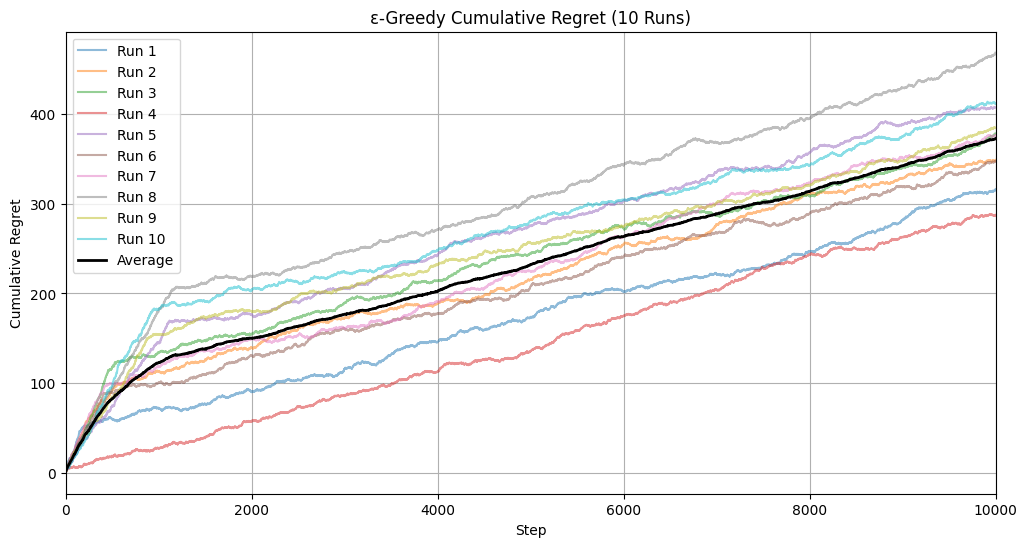

✅ Total execution time: 0.16 seconds


In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
import os
# Load preprocessed data
def load_preprocessed_data(save_path = "./save"):   
    with open(os.path.join(save_path, "arms.json"), "r") as f:
        arms = json.load(f)
    with open(os.path.join(save_path, "rewards.json"), "r") as f:
        rewards = json.load(f)
    return arms, rewards

# ε-Greedy strategy
def epsilon_greedy(K, n, reward_lists, epsilon=0.1):
    np.random.seed(int(time.time()))
    random.seed(time.time())
    
    # Initialize variables
    T = np.zeros(K)  # Number of times each arm has been pulled
    reward_sums = np.zeros(K)  # Sum of rewards for each arm
    estimated_means = np.zeros(K)  # Estimated mean reward for each arm
    cumulative_regrets = np.zeros(n)  # Cumulative regrets over time
    optimal_mean = max(np.mean(reward_list) for reward_list in reward_lists)  # True optimal mean
    
    for t in range(n):
        if random.random() < epsilon:
            # Exploration: Choose a random arm
            chosen_arm = random.randint(0, K-1)
        else:
            # Exploitation: Choose the arm with the highest estimated mean
            chosen_arm = np.argmax(estimated_means)
        
        # Pull the chosen arm and get the reward
        reward = random.choice(reward_lists[chosen_arm])
        
        # Update the statistics for the chosen arm
        T[chosen_arm] += 1
        reward_sums[chosen_arm] += reward
        estimated_means[chosen_arm] = reward_sums[chosen_arm] / T[chosen_arm]
        
        # Calculate the regret for this step
        cumulative_regrets[t] = optimal_mean - reward
    
    # Calculate cumulative regrets
    cumulative_regrets = np.cumsum(cumulative_regrets)
    
    return cumulative_regrets

# Load preprocessed data
arms, rewards = load_preprocessed_data()
reward_lists = list(rewards.values())  # Use preprocessed rewards
K = len(arms)  # Number of arms (genres)

# Example parameters
n = 10000  # Total time steps

# Run ε-Greedy algorithm ten times
epsilon = 0.1  # Exploration probability
num_runs = 10
all_cumulative_regrets = np.zeros((num_runs, n))

for run in range(num_runs):
    cumulative_regrets = epsilon_greedy(K, n, reward_lists, epsilon)
    all_cumulative_regrets[run, :] = cumulative_regrets

# Calculate average cumulative regret
mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)

# Plot cumulative regrets for each run and the average
plt.figure(figsize=(12, 6))

# Plot each run
for run in range(num_runs):
    plt.plot(all_cumulative_regrets[run, :], label=f'Run {run + 1}', alpha=0.5)

# Plot average cumulative regret
plt.plot(mean_cumulative_regrets, label='Average', color='black', linewidth=2)


# Add timing start
start_time = time.time()

plt.title('ε-Greedy Cumulative Regret (10 Runs)')
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.xlim(0, n)
plt.legend()
plt.grid(True)
plt.show()

end_time = time.time()
print(f"✅ Total execution time: {end_time - start_time:.2f} seconds")

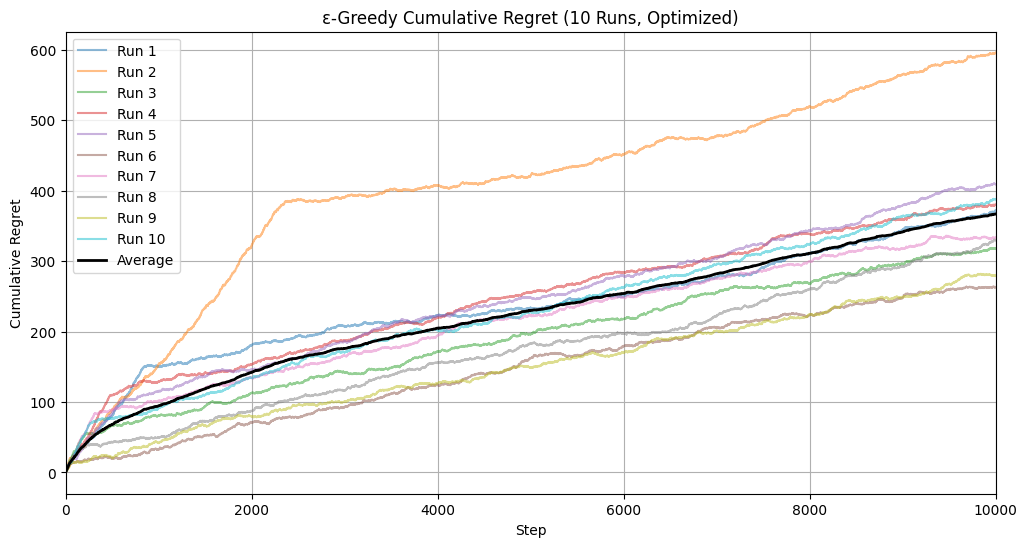

✅ Total execution time: 0.81 seconds


In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import os
from joblib import Parallel, delayed  # ✅ Optimization 4: parallel execution

# ✅ Load preprocessed data
def load_preprocessed_data(save_path="./save"):
    with open(os.path.join(save_path, "arms.json"), "r") as f:
        arms = json.load(f)
    with open(os.path.join(save_path, "rewards.json"), "r") as f:
        rewards = json.load(f)
    return arms, rewards

# ✅ Optimized ε-Greedy algorithm
def epsilon_greedy(K, n, reward_lists, epsilon=0.1, seed_offset=0):
    np.random.seed(42 + seed_offset)  # ✅ Optimization 1: reproducible randomness
    random.seed(42 + seed_offset)

    T = np.zeros(K)  # Arm pull counts
    estimated_means = np.zeros(K)  # Estimated means
    cumulative_regrets = np.zeros(n)
    optimal_mean = max(np.mean(r) for r in reward_lists)

    for t in range(n):
        if random.random() < epsilon:
            chosen_arm = random.randint(0, K - 1)  # Explore
        else:
            chosen_arm = np.argmax(estimated_means)  # Exploit

        reward = random.choice(reward_lists[chosen_arm])
        T[chosen_arm] += 1

        # ✅ Optimization 2: Welford mean update
        estimated_means[chosen_arm] += (reward - estimated_means[chosen_arm]) / T[chosen_arm]

        # ✅ Optimization 3: Incremental cumulative regret
        regret = optimal_mean - reward
        if t == 0:
            cumulative_regrets[t] = regret
        else:
            cumulative_regrets[t] = cumulative_regrets[t - 1] + regret

    return cumulative_regrets

# ✅ Parameters
arms, rewards = load_preprocessed_data()
reward_lists = list(rewards.values())
K = len(arms)
n = 10000
epsilon = 0.1
num_runs = 10

# ✅ Optimization 5: start timing
start_time = time.time()

# ✅ Optimization 4: parallel execution of 10 runs
all_cumulative_regrets = Parallel(n_jobs=-1)(
    delayed(epsilon_greedy)(K, n, reward_lists, epsilon, run) for run in range(num_runs)
)
all_cumulative_regrets = np.array(all_cumulative_regrets)
mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)

# ✅ Plotting
plt.figure(figsize=(12, 6))
for run in range(num_runs):
    plt.plot(all_cumulative_regrets[run], label=f'Run {run + 1}', alpha=0.5)
plt.plot(mean_cumulative_regrets, label='Average', color='black', linewidth=2)

plt.title('ε-Greedy Cumulative Regret (10 Runs, Optimized)')
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.xlim(0, n)
plt.legend()
plt.grid(True)
plt.show()

# ✅ Print total runtime
end_time = time.time()
print(f"✅ Total execution time: {end_time - start_time:.2f} seconds")

# ------------------------------------------
# ORIGINAL (UNOPTIMIZED) CODE (COMMENTED):
# ------------------------------------------
# np.random.seed(int(time.time()))
# random.seed(time.time())
# reward_sums = np.zeros(K)
# estimated_means[chosen_arm] = reward_sums[chosen_arm] / T[chosen_arm]
# cumulative_regrets = np.cumsum(cumulative_regrets)
# for run in range(num_runs):
#     cumulative_regrets = epsilon_greedy(K, n, reward_lists, epsilon)
#     all_cumulative_regrets[run, :] = cumulative_regrets


In [6]:
# After optimising ε-Greedy, why did the runtime slow down? This is actually a common misconception 
# ‘code structure optimisation ≠ will definitely be faster’,especially in small data sets or lightweight algorithms.
# The code is more stable, more reproducible, and more scalable, but its speed advantage is only apparent in ‘large-scale experiments.’
